In [1]:
!pip install albumentations
!pip install torchmetrics
!pip install paddleocr>=2.0.1 paddlepaddle
!pip install opencv-python-headless==4.5.3.56
!pip install segmentation_models_pytorch

In [7]:
%%time
## STANDARD LIBRARY AND PIPELINE MODULES IMPORT
import warnings
warnings.filterwarnings("ignore")
# from pipeline import segmentation
# from pipeline import correct_perspective
# from pipeline import text_detection
from pipeline import OCR
from pipeline import classifier
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

Wall time: 2.8 s


In [164]:
class Rules:   

    def __init__(self):
        pass

    def _txt_len(self, text):
        ##avoiding string containing long texts as it will be generally something else
        if len(text)>7:
            return False
        return True

    def _is_alpha(self, text):
        ##avoiding string containing alphabets
        if re.search('\d+', text)==None:
            return False
        return True
    def _pre_check(self, text):
        ## pre checking for valid characters
        valid = True
        valid = (self._txt_len(text) and valid)
        valid = (self._is_alpha(text) and valid)
        return valid

    def BPRule(self, text):
        sbp = 0
        dbp = 0
        pos = text.find("/")
        # print("POS - ", pos)
        if pos!=-1:
            sbp = text[max(pos-3, 0):pos]
            dbp = text[pos+1:pos+4]
            return True, [sbp, dbp]
        else:
            return False, None

    def check_green(self, cropped):
        normalizedImg = np.zeros((cropped.shape[0], cropped.shape[1]))
        cropped = cv2.normalize(cropped,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
        hsv = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (40, 40, 50), (80, 255,255))
        imask = mask>0
        area = cropped.shape[0]*cropped.shape[1]
        thres = 0.16
#         print(imask.sum()/area)
        if (imask.sum()/area) > thres and area > self.min_area:    
            return True
        return False
    
    def check_map(self, text):
        if re.search('\(.*\d+\)', text)==None:
            return False
        return True
    
    def check_yellow(self, cropped):
        normalizedImg = np.zeros((cropped.shape[0], cropped.shape[1]))
        cropped = cv2.normalize(cropped,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
        hsv = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (20, 50, 50), (40, 255, 255))
        imask = mask>0
        area = cropped.shape[0]*cropped.shape[1]
#         print(imask.sum()/area)
        thres = 0.15
        if (imask.sum()/area) > thres and area > self.min_area:    
            return True
        return False
    def check_cyan(self, cropped):
        normalizedImg = np.zeros((cropped.shape[0], cropped.shape[1]))
        cropped = cv2.normalize(cropped,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
        hsv = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (80, 50, 60), (100, 255,255))
        imask = mask>0
        area = cropped.shape[0]*cropped.shape[1]
        thres = 0.15        
        if (imask.sum()/area) > thres and area > self.min_area:    
            return True
        return False
    
    def class_pred(self, text, cropped, label):
        self.min_area = 300
        if label == 1:
            self.min_area = 700
        valid = self._pre_check(text)
        
        if valid:
            hr = self.check_green(cropped)
            map_check = self.check_map(text)
            yellow = self.check_yellow(cropped)
            cyan = self.check_cyan(cropped)
            bp = self.BPRule(text)
            if bp[0]:
                return "BP", [("SBP", bp[1][0]), ("DBP", bp[1][1])]
            elif hr:
                return "HR", [text]
            elif map_check:
                return "MAP", int(text[1:len(text)-1])
            elif yellow:
                return "yellow", (text)
            elif cyan:
                return 'cyan', (text)
            else:
                return "null"     
        else:
            return "Invalid text"


ru = Rules()

In [63]:
abs(-3)

3

index: 30
[2023/02/05 23:58:44] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/02/05 23:58:44] ppocr DEBUG: dt_boxes num : 6, elapse : 0.0690157413482666
[2023/02/05 23:58:46] ppocr DEBUG: rec_res num  : 6, elapse : 1.559361219406128


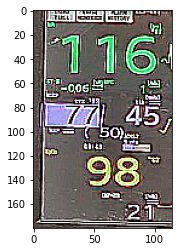

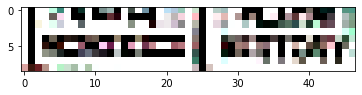

Y


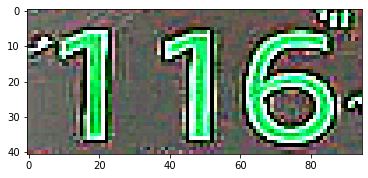

116


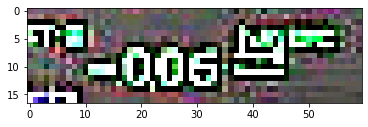

T-006


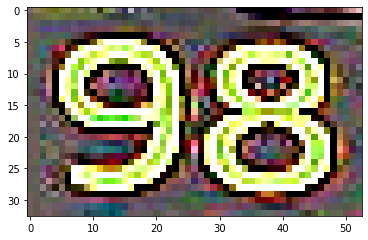

98


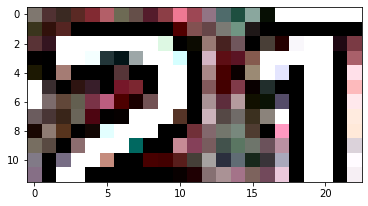

21
{'SPO2': '98', 'HR': 116, 'RR': '21'}
accuracy:  0.0


In [174]:

import os
import cv2
import matplotlib.pyplot as plt

def find_nearby(slash_box, boxes):
    X, Y, W, H, _ = slash_box
    ans_index = -1
    min_del_y = 1e5
    for i in range(len(boxes)):
        x,y,w,h, _ = boxes[i]
        if x < X:
            if min_del_y > abs(y-Y):
                min_del_y = abs(y-Y)
                ans_index = i
    return ans_index


correct = 0

## EVALUATION ON EACH IMAGE
img_classes = [ 'BPL-EliteView-EV10-B_Meditec-England-A', 'BPL-EliteView-EV100-C' , 'BPL-Ultima-PrimeD-A' , 'Nihon-Kohden-lifescope-A']
TEST_IMG_DIR = f"val/{img_classes[3]}"
for index in range(30, 31):
    imlis = os.listdir(TEST_IMG_DIR)
    imloc = f"{TEST_IMG_DIR}/{imlis[index]}"

    image = cv2.cvtColor(cv2.imread(imloc), cv2.COLOR_BGR2RGB)
    ocr_io = cv2.resize(image, (320, 180))
    class_io = cv2.resize(image, (640, 360))
    # only for class 1
    
    print(f'index: {index}')
    
    
    # mask = segmentation.maskPred(image)
    # # print(mask)
    # (ocr_io, class_io, orig_io) =  correct_perspective.correctPerspective(image, mask)
    label = classifier.classification(class_io) 
    
    #label = 2
    if label==1:
        candidates =  OCR.get_text(class_io, det=True)
        ocr_io = class_io
    elif label == 3:
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        ocr_io = cv2.filter2D(ocr_io, -1, kernel)
        
        candidates =  OCR.get_text(ocr_io[:, :115], det=True)
    else:
        print("here")
        candidates =  OCR.get_text(ocr_io, det=True)
    can = candidates[0]
    plt.imshow(ocr_io[:, :115])
    plt.show()

    result = {}
    hr_boxes = []
    
    boxes = []
    yellow_boxes = []
    slash_box = []
    for line in can:
        bbox = line[0]
        txt = line[1][0]
        confidence = line[1][1]
        
        x1, y1, x2, y2 = int(bbox[0][0]),int(bbox[0][1]) , int(bbox[2][0]),int(bbox[2][1])
        cropped = ocr_io[y1: y2, x1:x2]
#         print(x1,y1,x2,y2)
        plt.imshow(cropped)
        plt.show()
    
#         # print(bbox, txt, confidence)
        pred = ru.class_pred(txt, cropped, label)
#         print(pred)
        if len(re.findall("^/\d+", txt.strip()))>0:
            slash_box = [(x1+x2)/2, (y1+y2)/2, x2-x1,y2-y1, txt ]
        else:
            boxes.append([(x1+x2)/2, (y1+y2)/2, x2-x1,y2-y1, txt ])
        print(txt)
        if len(pred)>0:
            clas = pred[0]
#             print(clas, label)
            if(clas=="BP"):
                result[pred[1][0][0]] = pred[1][0][1]
                result[pred[1][1][0]] = pred[1][1][1]
            elif(clas == 'HR'):
                hr_boxes.append([cropped.shape[0]*cropped.shape[1], [x1,y1,x2,y2], pred])
            elif(clas == 'cyan'):
                if label == 1:
                    result['RR'] = pred[1]
                elif label==0 or label == 2: 
                    result['SPO2'] = pred[1]
            elif(clas=='yellow'):
                if label == 1:
                    yellow_boxes.append([(y1+y2)/2, cropped.shape[0]*cropped.shape[1], [x1,y1,x2,y2], txt])
                elif label == 0 or label == 2:
                    result['RR'] = txt
                elif label == 3:
                    result['SPO2'] = txt
                    
#         print(txt ,"-", len(pred))
    yellow_boxes = sorted(yellow_boxes, key=lambda x: x[0], reverse=True)
    hr_boxes = sorted(hr_boxes, key=lambda x: x[0], reverse=True)
    
    if label == 1 and len(yellow_boxes) > 0:
        result['SPO2'] = yellow_boxes[0][3]
    
    if len(hr_boxes)>0:
        x1,y1,x2,y2 = hr_boxes[0][1]
        hr = (hr_boxes[0][2][1][0])
        a = re.findall('^\d+', hr)
        hr = int(a[0])
        if int(a[0][:3]) > 220:
            hr = int(a[0][:2])
        elif int(a[0]) > 300:
            hr = int(a[0][:3])
        result['HR'] = hr
#         plt.imshow(ocr_io[y1: y2, x1:x2])
#         plt.show()
    
    if len(slash_box) > 0:
        print('imhere')
        print(slash_box)
        index = find_nearby(slash_box, boxes)
        x, y, w, h, pred = boxes[index]
        
        result['SBP'] = pred.strip()
        result['DBP'] = slash_box[-1][1:]
    
    boxes = sorted(boxes, key= lambda x: x[1], reverse=True)
    if label == 3:
        for (x,y,w,h,pred) in boxes:
            if w*h > 200:
                if pred[1] == 'T':
                    pred = pred[0] + '7'
                result['RR'] = pred
                break
    
    
    if(len(result) == 5):
        correct+=1
    
    print(result)
print('accuracy: ', correct/40)

# bounding_boxes1 = list(np.expand_dims(np.round(np.array(bounding_boxes)).astype(np.int32), 2))

# fig, ax = plt.subplots(len(bounding_boxes) + 1, 2, figsize = (40, 200))

# croplis = []
# texlis = []

# for idx in range(len(bounding_boxes)):
#     img = cv2.cvtColor(class_io, cv2.COLOR_BGR2GRAY)
#     # mask = np.zeros_like(img) # Create mask where white is what we want, black otherwise
#     # cv2.drawContours(mask, bounding_boxes1, idx, 255, -1) # Draw filled contour in mask
#     # out = np.zeros_like(img) # Extract out the object and place into output image
#     # out[mask == 255] = img[mask == 255]
    
#     # ax[idx][0].imshow(out)
#     # print(bounding_boxes[idx][0])
#     text, crop = OCR.trOCR(class_io, bounding_boxes[idx])
    
#     # ax[idx][1].imshow(crop)
#     # ax[idx][1].set_xlabel(f"{text}, {len(text)}")
    
#     croplis.append(crop)
#     texlis.append(text)
    
# # ax[-1][0].imshow(image)
# # ax[-1][1].imshow(class_io)

# # fig, ax = plt.subplots(len(bounding_boxes) + 1)

# # for idx,bounding_box in enumerate(bounding_boxes):
# #     text, crop = OCR.trOCR(detector_io, bounding_box)

# #     print(text)
# #     ax[idx].imshow(crop)
# # ax[-1].imshow(monitor)

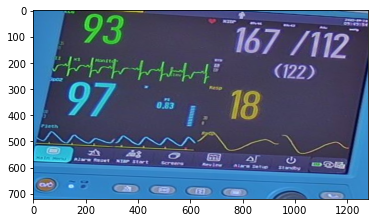

In [42]:
[23,28,33, 39]

In [120]:
print(label)

3


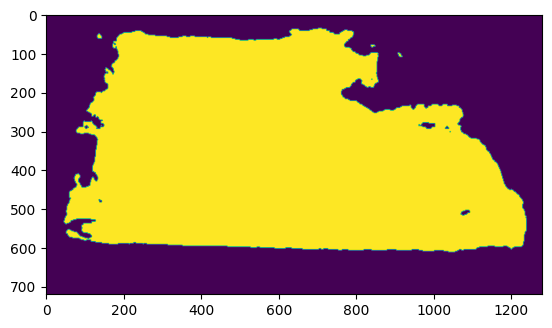

In [66]:
plt.imshow(mask)

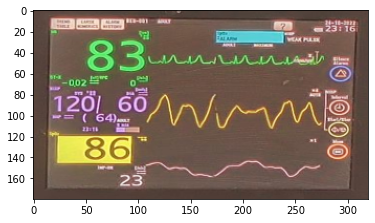

In [127]:
plt.imshow(ocr_io)

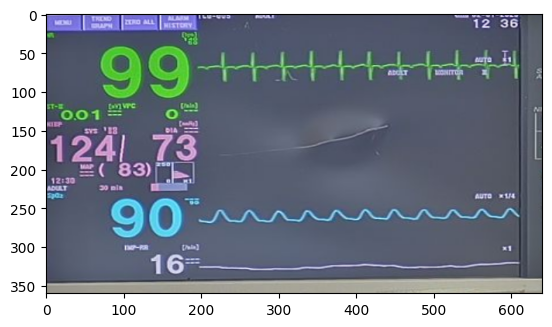

In [6]:
plt.imshow(class_io)

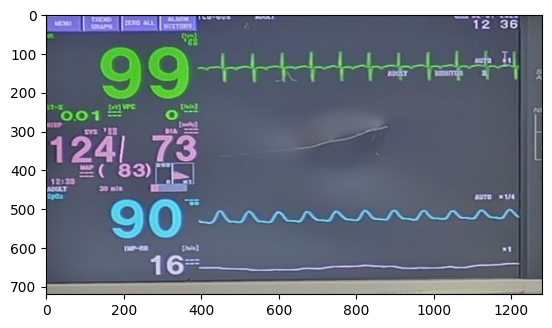

In [7]:
plt.imshow(orig_io)

In [8]:
result=result[0]
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
bounding_boxes1 = list(np.expand_dims(np.round(np.array(boxes)).astype(np.int32), 2))

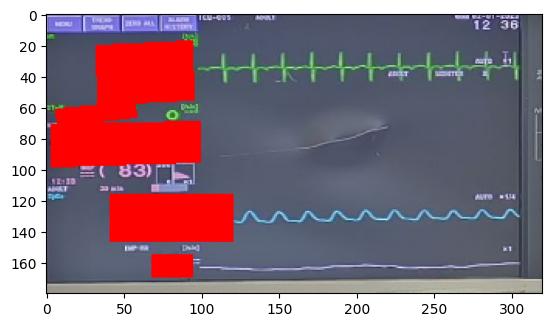

In [9]:
plt.imshow(cv2.drawContours(_io, bounding_boxes1, -1, 255, -1)) # Draw filled contour in mask

0.17659804983748645


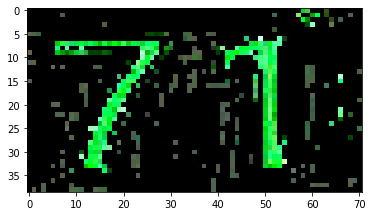

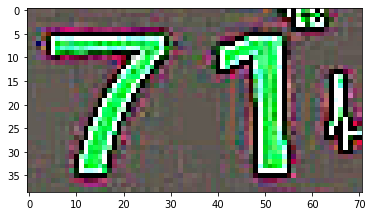

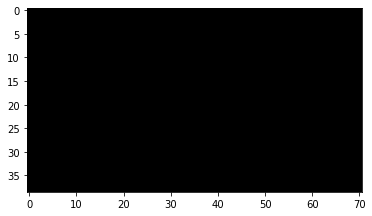

In [163]:
import cv2
x1, y1, x2, y2 = 43, 20, 114, 59


cropped = ocr_io[y1: y2, x1:x2]
normalizedImg = np.zeros((800, 800))
cropped = cv2.normalize(cropped,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
hsv = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, (40, 40, 50), (80, 255,255))
imask = mask>0
green = np.zeros_like(cropped, np.uint8)
green[imask] = cropped[imask]
normalizedImg = np.zeros(cropped.shape)

print(imask.sum()/(cropped.shape[0]*cropped.shape[1]))
plt.imshow(green)
plt.show()
plt.imshow(cropped)
plt.show()
plt.imshow(normalizedImg)
plt.show()

In [223]:
txt = ' /43'
len(re.findall("^/\d+", txt.strip()))>0
    

['/43']

In [126]:
import requests
payload=  {
    'isOverlayRequired': True,
     'apikey': 'K86565545188957',
    'language': 'eng',
     'OCREngine':2,
}
with open(f"{TEST_IMG_DIR}/{imlis[0]}", 'rb') as f:
    r = requests.post('https://api.ocr.space/parse/image',
                      files={'filename': f},
                      data=payload,
                      )

    print(r.content.decode())


KeyboardInterrupt: 